本实验使用的训练数据集是经典学术数据集“波士顿房价”数据，使用飞桨开源框架构建自定义的前馈神经网络，实现房价预测的回归任务。

实现房价预测包含4个部分，如 **图1** 所示：
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1aa7f87f322d425fb6ae00d5d80a1f6e5630a6bf2334495abe92a737782b9599" width="700" hegiht="" ></center>

<center><br>图1 训练流程</br></center>

# 1.准备数据

# 1.1 数据集介绍
波士顿房价预测数据集来自 UCI 机器学习知识库（数据集已下线），于 1978 年开始统计，数据集中的每一行数据都是对波士顿周边或城镇房价的情况描述，总共有 506 行，即 506 个样本，该数据集统计了 13 种可能影响房价的因素和该类型房屋的均价，期望构建一个基于 13 个因素进行房价预测的模型，如 **图2** 所示。
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/abce0cb2a92f4e679c6855cfa520491597171533a0b0447e8d51d904446e213e" width="700" hegiht="" ></center>
<center><br>图2 波士顿房价影响因素示意图</br></center>
<br></br>

In [2]:
# 导入环境
import paddle
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

print(paddle.__version__)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


2.1.0


## 1.2 数据准备

In [4]:
#下载数据，只执行一次就可以
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data -O housing.data 

--2021-07-10 16:40:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [application/x-httpd-php]
Saving to: ‘housing.data’

housing.data        100%[===================>]  47.93K  91.2KB/s    in 0.5s    

2021-07-10 16:40:29 (91.2 KB/s) - ‘housing.data’ saved [49082/49082]



In [5]:
# 从文件导入数据
datafile = './housing.data'
housing_data = np.fromfile(datafile, sep=' ')
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
feature_num = len(feature_names)
print('feature num:', feature_num)
# 将原始数据进行Reshape，变成[N, 14]这样的形状
housing_data = housing_data.reshape([housing_data.shape[0] // feature_num, feature_num])
print('data num:',len(housing_data))

feature num: 14
data num: 506


## 1.3 数据预处理

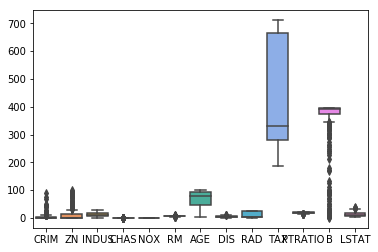

In [6]:
# 画图看特征间的关系,主要是变量两两之间的关系（线性或非线性，有无明显较为相关关系）
features_np = np.array([x[:13] for x in housing_data], np.float32)
labels_np = np.array([x[-1] for x in housing_data], np.float32)
df = pd.DataFrame(housing_data, columns=feature_names)
sns.boxplot(data=df.iloc[:, 0:13])

从上图看出，各属性的数值范围差异太大，甚至不能够在一个画布上充分的展示各属性具体的最大、最小值以及异常值等。下面进行归一化。

做归一化（或 Feature scaling）至少有以下2个理由：

* 过大或过小的数值范围会导致计算时的浮点上溢或下溢。

* 不同的数值范围会导致不同属性对模型的重要性不同（至少在训练的初始阶段如此），而这个隐含的假设常常是不合理的。这会对优化的过程造成困难，使训练时间大大的加长.

In [7]:
features_max = housing_data.max(axis=0)
features_min = housing_data.min(axis=0)
features_avg = housing_data.sum(axis=0) / housing_data.shape[0]

BATCH_SIZE = 20
def feature_norm(input):
    f_size = input.shape
    output_features = np.zeros(f_size, np.float32)
    for batch_id in range(f_size[0]):
        for index in range(13):
            output_features[batch_id][index] = (input[batch_id][index] - features_avg[index]) / (features_max[index] - features_min[index])
    return output_features 

# 只对属性进行归一化
housing_features = feature_norm(housing_data[:, :13])
# print(feature_trian.shape)
housing_data = np.c_[housing_features, housing_data[:, -1]].astype(np.float32)
# print(training_data[0])


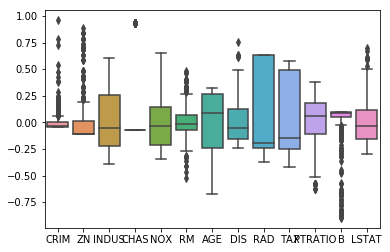

In [8]:
# 归一化后的train_data, 看下各属性的情况
features_np = np.array([x[:13] for x in housing_data],np.float32)
labels_np = np.array([x[-1] for x in housing_data],np.float32)
data_np = np.c_[features_np, labels_np]
df = pd.DataFrame(data_np, columns=feature_names)
sns.boxplot(data=df.iloc[:, 0:13])

## 1.4 划分数据集

In [9]:
# 将训练数据集和测试数据集按照8:2的比例分开
ratio = 0.8
offset = int(housing_data.shape[0] * ratio)
train_data = housing_data[:offset]
test_data = housing_data[offset:]


# 2. 模型构建

提供2种模型，使用任意一种即可：
* 单层网络
* 2层网络

In [10]:
# 神经网络，选择2
class Regressor(paddle.nn.Layer):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = paddle.nn.Linear(in_features=13, out_features=6,)
        self.fc2 = paddle.nn.Linear(in_features=6, out_features=1,)
        # 定义网络使用的激活函数
        # (2)修改激活函数，self.act
        self.act = paddle.nn.Sigmoid()
        # self.act = paddle.nn.ReLU()

    def forward(self, inputs):
        outputs = self.fc1(inputs)
        outputs = self.act(outputs)
        pred = self.fc2(outputs)
        return pred

# 3. 模型训练

In [11]:
import paddle.nn.functional as F 
import shutil
y_preds = []
labels_list = []
train_nums = []
train_costs = []

def train(model):
    print('start training ... ')
    save_path = './output/'
    # os.makedirs(save_path, exist_ok=False)
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    else:
        shutil.rmtree(save_path)

    # 开启模型训练模式
    model.train()
    #（3）修改训练轮数，EPOCH_NUM = *
    EPOCH_NUM = 10
    # EPOCH_NUM = 100
    # EPOCH_NUM = 500
    train_num = 0
    min_cost = 30000
    #（4）修改优化算法，paddle.optimizer.*
    # (5) 修改学习率，learning_rate=*
    optimizer = paddle.optimizer.SGD(learning_rate=0.00001, parameters=model.parameters())
    # optimizer = paddle.optimizer.Momentum(learning_rate=0.001, parameters=model.parameters())
    # optimizer = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    # optimizer = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(train_data)
        # 将训练数据进行拆分，每个batch包含20条数据
        mini_batches = [train_data[k: k+BATCH_SIZE] for k in range(0, len(train_data), BATCH_SIZE)]
        for batch_id, data in enumerate(mini_batches):
            features_np = np.array(data[:, :13], np.float32)
            labels_np = np.array(data[:, -1:], np.float32)
            features = paddle.to_tensor(features_np)
            labels = paddle.to_tensor(labels_np)
            # 前向计算
            y_pred = model(features)
            cost = F.mse_loss(y_pred, label=labels)
            train_cost = cost.numpy()[0]
            # 反向传播
            cost.backward()
            # 最小化loss，更新参数
            optimizer.step()
            # 清除梯度
            optimizer.clear_grad()
            
            if batch_id%30 == 0 and epoch_id%50 == 0:
                print("Pass:%d,Cost:%0.5f"%(epoch_id, train_cost))

            train_num = train_num + BATCH_SIZE
            train_nums.append(train_num)
            train_costs.append(train_cost)

            if train_cost < min_cost:
                min_cost = train_cost
                save_name = save_path+'best_acc.pdparams'
                paddle.save(model.state_dict(), save_name)
        
model = Regressor()
train(model)


start training ... 
Pass:0,Cost:518.85876


# 4.模型预测

In [12]:
# 获取预测数据
INFER_BATCH_SIZE = 100

infer_features_np = np.array([data[:13] for data in test_data]).astype("float32")
infer_labels_np = np.array([data[-1] for data in test_data]).astype("float32")

model_dict = paddle.load('output/best_acc.pdparams')
model.load_dict(model_dict)
model.eval()

infer_features = paddle.to_tensor(infer_features_np)
infer_labels = paddle.to_tensor(infer_labels_np)
fetch_list = model(infer_features)

sum_cost = 0
for i in range(INFER_BATCH_SIZE):
    infer_result = fetch_list[i][0]
    ground_truth = infer_labels[i]
    if i % 10 == 0:
        print("No.%d: infer result is %.2f,ground truth is %.2f" % (i, infer_result, ground_truth))
    cost = paddle.pow(infer_result - ground_truth, 2)
    sum_cost += cost
mean_loss = sum_cost / INFER_BATCH_SIZE
print("Mean loss is:", mean_loss.numpy())


No.0: infer result is 1.32,ground truth is 8.50
No.10: infer result is 1.43,ground truth is 7.00
No.20: infer result is 1.38,ground truth is 11.70
No.30: infer result is 1.41,ground truth is 11.70
No.40: infer result is 1.33,ground truth is 10.80
No.50: infer result is 1.44,ground truth is 14.90
No.60: infer result is 1.20,ground truth is 21.40
No.70: infer result is 1.26,ground truth is 13.80
No.80: infer result is 1.15,ground truth is 20.60
No.90: infer result is 1.16,ground truth is 24.50
Mean loss is: [243.72903]


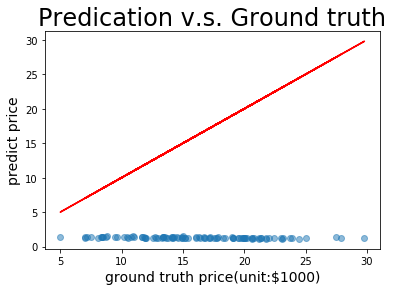

In [13]:
def plot_pred_ground(pred, ground):
    plt.figure()   
    plt.title("Predication v.s. Ground truth", fontsize=24)
    plt.xlabel("ground truth price(unit:$1000)", fontsize=14)
    plt.ylabel("predict price", fontsize=14)
    plt.scatter(ground, pred, alpha=0.5)  #  scatter:散点图,alpha:"透明度"
    plt.plot(ground, ground, c='red')
    plt.show()
plot_pred_ground(fetch_list, infer_labels_np)

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 